## Case study 1: Ảnh MNIST – Thiết kế 2 mô hình CNN có và không có Keras  
### • Mục tiêu: phân loại chữ số viết tay 
### • Tập data: MNIST + 100 ảnh sinh viên tự tạo ra. Thể hiện phân bố data  
### • Sinh viên mô tả: kiến trúc CNN + dropout + kết quả dự đoán + đánh giá 2 mô hình

1. Bước 1: Cài đặt và Import thư viện

In [6]:
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

2. Bước 2: Chuẩn bị dữ liệu

1. Đang tải MNIST...
2. Đang đọc ảnh từ folder: dataset/testSet...
-> Đã load được 100 ảnh của bạn.


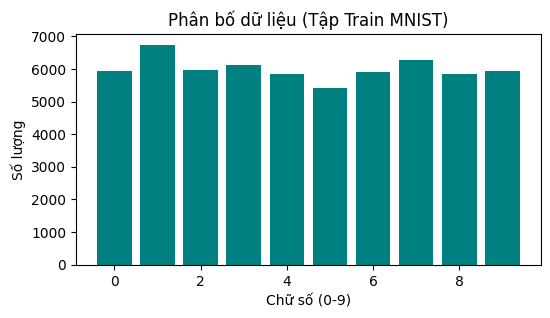

In [9]:
# ==========================================
# PHẦN 1: CHUẨN BỊ DỮ LIỆU
# ==========================================

# 1.1. Tải MNIST từ mạng (Dữ liệu nền tảng để train)
print("1. Đang tải MNIST...")
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# Chuẩn hóa về 0-1 và reshape
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# 1.2. Đọc 100 ảnh từ folder của bạn (dataset/testSet)
def load_custom_images(folder_path):
    images = []
    print(f"2. Đang đọc ảnh từ folder: {folder_path}...")
    
    if not os.path.exists(folder_path):
        print(f"⚠️ Lỗi: Không tìm thấy thư mục '{folder_path}'")
        return np.array([])

    count = 0
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            path = os.path.join(folder_path, filename)
            
            # Đọc ảnh chế độ xám (Grayscale)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            
            if img is not None:
                # Resize về 28x28 chuẩn MNIST
                img = cv2.resize(img, (28, 28))
                images.append(img)
                count += 1
                if count >= 100: break # Chỉ lấy 100 ảnh

    if len(images) > 0:
        # Chuyển thành mảng numpy và chuẩn hóa
        return np.array(images).reshape(-1, 28, 28, 1).astype('float32') / 255.0
    else:
        return np.array([])

# Đường dẫn đến folder của bạn
custom_path = 'dataset/testSet' 
x_custom = load_custom_images(custom_path)
print(f"-> Đã load được {len(x_custom)} ảnh của bạn.")

# 1.3. Thể hiện phân bố data (Dựa trên tập Train MNIST)
plt.figure(figsize=(6, 3))
plt.bar(*np.unique(y_train, return_counts=True), color='teal')
plt.title("Phân bố dữ liệu (Tập Train MNIST)")
plt.xlabel("Chữ số (0-9)")
plt.ylabel("Số lượng")
plt.show()

3. Mô hình có Keras

In [11]:
# ==========================================
# PHẦN 2: MÔ HÌNH 1 - CÓ KERAS (High Level)
# ==========================================
print("\n--- MODEL 1: CÓ KERAS ---")
model_keras = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'), # Thêm 1 lớp Conv cho mạnh hơn
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dropout(0.5), # Yêu cầu đề bài
    layers.Dense(10, activation='softmax')
])

model_keras.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Train
model_keras.fit(x_train, y_train, epochs=3, batch_size=64, validation_data=(x_test, y_test))


--- MODEL 1: CÓ KERAS ---
Epoch 1/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9221 - loss: 0.2587 - val_accuracy: 0.9800 - val_loss: 0.0650
Epoch 2/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9721 - loss: 0.0904 - val_accuracy: 0.9855 - val_loss: 0.0444
Epoch 3/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9785 - loss: 0.0678 - val_accuracy: 0.9876 - val_loss: 0.0373


4. Mô hình không Keras

In [12]:
# ==========================================
# PHẦN 3: MÔ HÌNH 2 - KHÔNG KERAS (Low Level)
# ==========================================
print("\n--- MODEL 2: KHÔNG DÙNG KERAS (Low-level API) ---")

# Định nghĩa biến W, b thủ công
W1 = tf.Variable(tf.random.normal([3, 3, 1, 32], stddev=0.1))
b1 = tf.Variable(tf.zeros([32]))
W2 = tf.Variable(tf.random.normal([3, 3, 32, 64], stddev=0.1))
b2 = tf.Variable(tf.zeros([64]))
# Sau 2 lần pool (28->14->7), ảnh còn 7x7, depth 64
W3 = tf.Variable(tf.random.normal([7*7*64, 10], stddev=0.1)) 
b3 = tf.Variable(tf.zeros([10]))

def model_no_keras(x, is_training=False):
    # Layer 1
    x = tf.nn.conv2d(x, W1, strides=1, padding='SAME') + b1
    x = tf.nn.relu(x)
    x = tf.nn.max_pool2d(x, ksize=2, strides=2, padding='SAME')
    
    # Layer 2
    x = tf.nn.conv2d(x, W2, strides=1, padding='SAME') + b2
    x = tf.nn.relu(x)
    x = tf.nn.max_pool2d(x, ksize=2, strides=2, padding='SAME')
    
    # Flatten & Dense
    x = tf.reshape(x, [-1, 7*7*64])
    if is_training: x = tf.nn.dropout(x, 0.5)
    return tf.nn.softmax(tf.matmul(x, W3) + b3)

# Train Loop
opt = tf.optimizers.Adam(learning_rate=0.001)
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(64)

for epoch in range(3): # Chạy 3 epoch
    loss_avg = tf.keras.metrics.Mean()
    for x_b, y_b in dataset:
        with tf.GradientTape() as tape:
            pred = model_no_keras(x_b, is_training=True)
            loss = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_b, pred))
        grads = tape.gradient(loss, [W1, b1, W2, b2, W3, b3])
        opt.apply_gradients(zip(grads, [W1, b1, W2, b2, W3, b3]))
        loss_avg(loss)
    print(f"Epoch {epoch+1}: Loss = {loss_avg.result():.4f}")


--- MODEL 2: KHÔNG DÙNG KERAS (Low-level API) ---
Epoch 1: Loss = 0.3016
Epoch 2: Loss = 0.0949
Epoch 3: Loss = 0.0705


5. ĐÁNH GIÁ & DỰ ĐOÁN TRÊN DATA CỦA BẠN


--- KẾT QUẢ DỰ ĐOÁN TRÊN ẢNH TRONG FOLDER 'dataset/testSet' ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


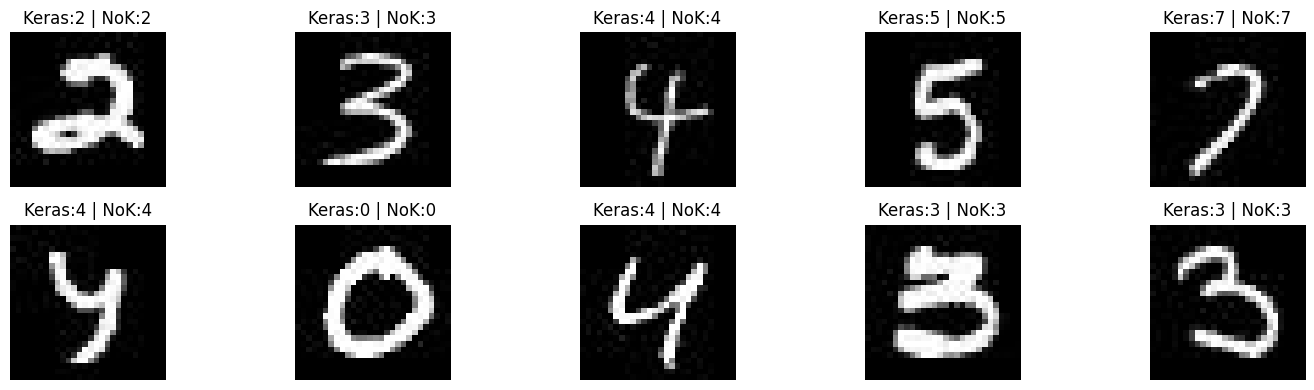

Đã hiển thị 10 ảnh mẫu từ folder của bạn.

Độ chính xác trên tập Test chuẩn (MNIST) - Keras: 98.76%


In [13]:
# ==========================================
# PHẦN 4: ĐÁNH GIÁ & DỰ ĐOÁN TRÊN DATA CỦA BẠN
# ==========================================
print("\n--- KẾT QUẢ DỰ ĐOÁN TRÊN ẢNH TRONG FOLDER 'dataset/testSet' ---")

if len(x_custom) > 0:
    # 1. Dự đoán bằng Model Keras
    preds_keras = model_keras.predict(x_custom)
    labels_keras = np.argmax(preds_keras, axis=1)
    
    # 2. Dự đoán bằng Model Không Keras
    preds_no_keras = model_no_keras(x_custom, is_training=False)
    labels_no_keras = np.argmax(preds_no_keras, axis=1)
    
    # 3. Hiển thị 10 ảnh đầu tiên để kiểm tra
    plt.figure(figsize=(15, 4))
    num_show = min(10, len(x_custom))
    for i in range(num_show):
        plt.subplot(2, 5, i+1)
        plt.imshow(x_custom[i].reshape(28,28), cmap='gray')
        plt.title(f"Keras:{labels_keras[i]} | NoK:{labels_no_keras[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print("Đã hiển thị 10 ảnh mẫu từ folder của bạn.")
else:
    print("⚠️ Không có ảnh nào trong folder dataset/testSet để dự đoán.")

# Đánh giá độ chính xác tổng quát trên tập Test chuẩn (MNIST)
acc_keras = model_keras.evaluate(x_test, y_test, verbose=0)[1]
print(f"\nĐộ chính xác trên tập Test chuẩn (MNIST) - Keras: {acc_keras*100:.2f}%")

⏳ Đang thu thập dữ liệu từ Model Keras...
⏳ Đang thu thập dữ liệu từ Model Low-level (No-Keras)...
   -> Done Epoch 1/3
   -> Done Epoch 2/3
   -> Done Epoch 3/3

📊 Đang vẽ biểu đồ...


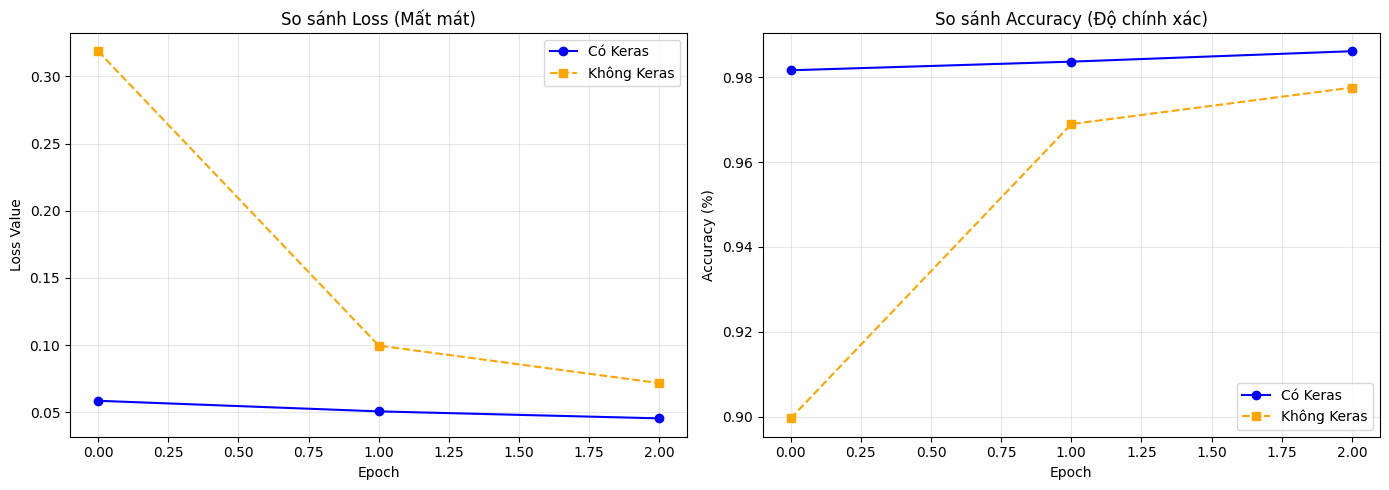

In [15]:
import matplotlib.pyplot as plt

# ==================================================================
# PHẦN NÀY TỰ ĐỘNG CHẠY LẠI TRAIN ĐỂ LẤY DỮ LIỆU VẼ BIỂU ĐỒ
# (Vì code cũ chỉ in ra màn hình chứ chưa lưu vào biến nhớ)
# ==================================================================

print("⏳ Đang thu thập dữ liệu từ Model Keras...")
# Reset và train lại Keras để lấy biến 'history'
model_keras.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model_keras.fit(x_train, y_train, epochs=3, batch_size=64, verbose=0)

print("⏳ Đang thu thập dữ liệu từ Model Low-level (No-Keras)...")
# Tạo list để chứa kết quả
loss_no_keras = []
acc_no_keras = []

# Reset lại trọng số cho Model No-Keras để train từ đầu (cho công bằng)
W1 = tf.Variable(tf.random.normal([3, 3, 1, 32], stddev=0.1))
b1 = tf.Variable(tf.zeros([32]))
W2 = tf.Variable(tf.random.normal([3, 3, 32, 64], stddev=0.1))
b2 = tf.Variable(tf.zeros([64]))
W3 = tf.Variable(tf.random.normal([7*7*64, 10], stddev=0.1))
b3 = tf.Variable(tf.zeros([10]))
optimizer = tf.optimizers.Adam(learning_rate=0.001)

# Vòng lặp train thủ công có lưu Loss/Acc
for epoch in range(3):
    epoch_loss = tf.keras.metrics.Mean()
    epoch_acc = tf.keras.metrics.SparseCategoricalAccuracy()
    
    for x_b, y_b in dataset:
        with tf.GradientTape() as tape:
            # Hàm model_no_keras dùng các biến W1, b1... toàn cục vừa reset ở trên
            pred = model_no_keras(x_b, is_training=True)
            loss = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_b, pred))
        
        grads = tape.gradient(loss, [W1, b1, W2, b2, W3, b3])
        optimizer.apply_gradients(zip(grads, [W1, b1, W2, b2, W3, b3]))
        
        epoch_loss.update_state(loss)
        epoch_acc.update_state(y_b, pred)
    
    loss_no_keras.append(epoch_loss.result())
    acc_no_keras.append(epoch_acc.result())
    print(f"   -> Done Epoch {epoch+1}/3")

# ==================================================================
# PHẦN VẼ BIỂU ĐỒ (LOSS & ACCURACY)
# ==================================================================
print("\n📊 Đang vẽ biểu đồ...")
plt.figure(figsize=(14, 5))

# 1. Biểu đồ Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Có Keras', marker='o', color='blue')
plt.plot(loss_no_keras, label='Không Keras', marker='s', linestyle='--', color='orange')
plt.title('So sánh Loss (Mất mát)')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Biểu đồ Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Có Keras', marker='o', color='blue')
plt.plot(acc_no_keras, label='Không Keras', marker='s', linestyle='--', color='orange')
plt.title('So sánh Accuracy (Độ chính xác)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()